# Introduccion y objetivo
Este trabajo se centra en detectar según imagenes el cáncer de piel de tipo melanoma. Ésta es una de las enfermedades mas graves en dermatología, y la detección temprana a través de imágenes es clave para reducir riesgos y mejorar tratamientos. El objetivo es entrenar un modelo de clasifiación binario de imágenes capaz de distinguir entre melanoma y no melanoma, exporando como distintos hiperparametros (como la tasa de aprendizaje, numero de epocas, tamaño de batch, regularizacion, entre otros) afectan el desempeño. La metrica principal para evaluar es el F1 Score.

# 1.- EDA

## Estructura del dataset y distribucion de datos

In [6]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

# Rutas Archivos

BASE_DIR = Path(r"C:\Users\nonit\Desktop\Universidad\melanoma detection\data")

train_mel_path   = BASE_DIR / "train" / "mel"
train_nomel_path = BASE_DIR / "train" / "nomel"
val_mel_path     = BASE_DIR / "valid" / "mel"
val_nomel_path   = BASE_DIR / "valid" / "nomel"
test_path        = BASE_DIR / "test"

test_csv = pd.read_csv(BASE_DIR / "test.csv")

# Conteo
def list_images(path):
    return [f for f in path.glob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]

train_mel_imgs = list_images(train_mel_path)
train_nomel_imgs = list_images(train_nomel_path)
val_mel_imgs = list_images(val_mel_path)
val_nomel_imgs = list_images(val_nomel_path)
test_imgs = list_images(test_path)

# Resumen

print("Estructura del dataset:")
print("train : imágenes para entrenamiento (subcarpetas 'mel', 'nomel')")
print("val   : imágenes para validación (subcarpetas 'mel', 'nomel')")
print("test  : imágenes para evaluación final (sin etiquetas, IDs en test.csv)")

print("\n___________ TRAIN ___________")
print(f"Melanoma    : {len(train_mel_imgs)}")
print(f"No Melanoma : {len(train_nomel_imgs)}")
print(f"Total       : {len(train_mel_imgs) + len(train_nomel_imgs)}")

print("\n___________ VALIDATION ___________")
print(f"Melanoma    : {len(val_mel_imgs)}")
print(f"No Melanoma : {len(val_nomel_imgs)}")
print(f"Total       : {len(val_mel_imgs) + len(val_nomel_imgs)}")

print("\n___________ TEST ___________")
print(f"Total imágenes en carpeta test : {len(test_imgs)}")
print(f"Total IDs en test.csv          : {len(test_csv)}")
if len(test_imgs) == len(test_csv):
    print("El número de imágenes en la carpeta test coincide con el número de IDs en test.csv.")

else:
    print("El número de imágenes en la carpeta test NO coincide con el número de IDs en test.csv.")


# Tipo de archivos

ext_train = set([img.suffix.lower() for img in train_mel_imgs + train_nomel_imgs])
ext_val = set([img.suffix.lower() for img in val_mel_imgs + val_nomel_imgs])
ext_test = set([img.suffix.lower() for img in test_imgs])

print("\n _______ FORMATOS _______")
print(f"Train: {ext_train}")
print(f"Val  : {ext_val}")
print(f"Test : {ext_test}")



Estructura del dataset:
train : imágenes para entrenamiento (subcarpetas 'mel', 'nomel')
val   : imágenes para validación (subcarpetas 'mel', 'nomel')
test  : imágenes para evaluación final (sin etiquetas, IDs en test.csv)

___________ TRAIN ___________
Melanoma    : 3644
No Melanoma : 3644
Total       : 7288

___________ VALIDATION ___________
Melanoma    : 1040
No Melanoma : 1040
Total       : 2080

___________ TEST ___________
Total imágenes en carpeta test : 1042
Total IDs en test.csv          : 1042
El número de imágenes en la carpeta test coincide con el número de IDs en test.csv.

 _______ FORMATOS _______
Train: {'.jpg'}
Val  : {'.jpg'}
Test : {'.jpg'}


## Visualización de ejemplos

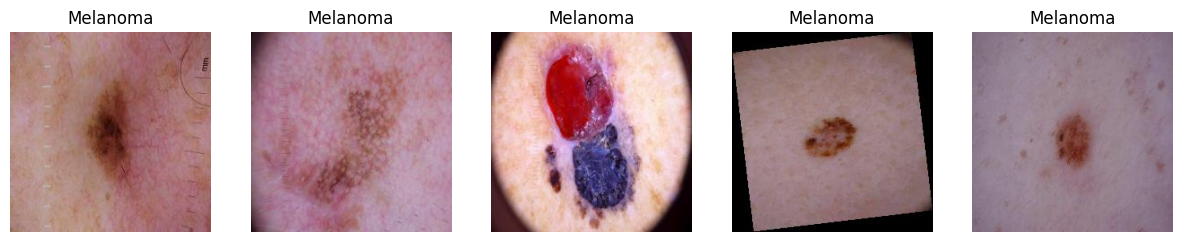

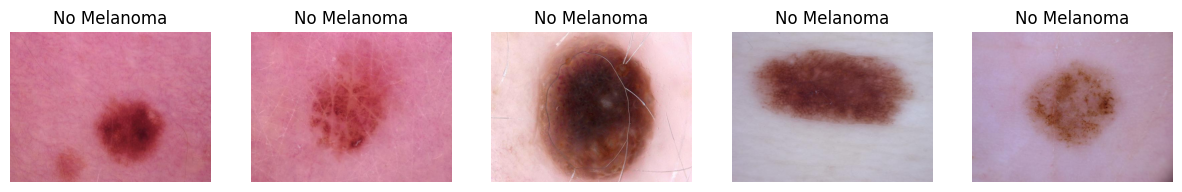

In [7]:
def show_examples(images, title, n=5):
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = random.choice(images)
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    plt.show()

show_examples(train_mel_imgs, "Melanoma")
show_examples(train_nomel_imgs, "No Melanoma")

## Balance de clases

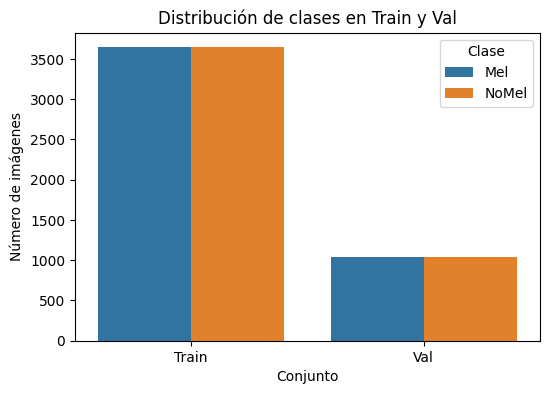

Relación Train Mel/NoMel: 1.00
Relación Val Mel/NoMel: 1.00


In [8]:
data_summary = pd.DataFrame({
    "Conjunto": ["Train", "Train", "Val", "Val"],
    "Clase": ["Mel", "NoMel", "Mel", "NoMel"],
    "Cantidad": [
        len(train_mel_imgs),
        len(train_nomel_imgs),
        len(val_mel_imgs),
        len(val_nomel_imgs)
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(data=data_summary, x="Conjunto", y="Cantidad", hue="Clase")
plt.title("Distribución de clases en Train y Val")
plt.ylabel("Número de imágenes")
plt.show()

# Ratios para ver balance
ratio_train = len(train_mel_imgs) / len(train_nomel_imgs)
ratio_val = len(val_mel_imgs) / len(val_nomel_imgs)

print(f"Relación Train Mel/NoMel: {ratio_train:.2f}")
print(f"Relación Val Mel/NoMel: {ratio_val:.2f}")

## Análisis

Podemos observar que se tienen 7288 datos de training y 2080 datos de validation, ambos distribuidos equitativamente en melanoma y n melanoma (50% de cada uno). Se observa con el ejemplo visual que no todas las imagenes estan derechas, que algunas esta, por ejemplo, rotadas. No se tiene un desbalance de clases, estan balanceadas.

# 2.- Preprocesamiento

### Redimensionamiento, normalización y preparación de imágenes 

In [9]:
import torch
from torchvision import transforms, datasets # para vision por computadora.
import numpy as np
import random

# REPRODUCIBILIDAD
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = 224 # tamaño estándar. Las imagenes se convertirán a 224x224 píxeles
BATCH_SIZE = 32 # tamaño del lote. El modelo aprendera en grupos de 32 imágenes

# Data Augmentation

train_transforms = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # redimensionar imagen a estandar 224x224
    transforms.RandomHorizontalFlip(p=0.5), # voltear la imagen con probabilidad 0.5
    transforms.RandomRotation(degrees=10), # rotar la imagen aleatoriamente hasta 10 grados
    transforms.ToTensor(), # convertir la imagen de formato imagen a tensor (numerico)
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # normalizar valores RGB
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # normalizar valores RGB
])

Esto nos deja con las imagenes redimensionadas para que todas sean de 224x224, adedmás de aplicarle cambios a algunas imagenes aleatoriamente como voltearla o rotarla, para que el modelo pueda reconocer melanomas del lado que sea y angulo que sea. Además se convierte la imagen a tensor y se normalizan los valores.

### Cargar datos y organizarlos en batches

In [15]:
# ---------CREAR DATASETS---------

train_dataset = datasets.ImageFolder(BASE_DIR / "train", transform=train_transforms) #ImageFolder organiza las imagenes en base a las carpetas
val_dataset = datasets.ImageFolder(BASE_DIR / "valid", transform=valid_transforms) #Toma la carpeta donde se encuentran las imagenes y les aplica las transformaciones

# ---------CORREGIR MAPEO DE CLASES---------
correct_mapping = {'nomel': 0, 'mel': 1}

# reemplazar el mapeo de clases en los datasets
train_dataset.class_to_idx = correct_mapping
val_dataset.class_to_idx = correct_mapping
train_dataset.classes = list(correct_mapping.keys())
val_dataset.classes = list(correct_mapping.keys())

# cambiar etiquetas
new_train_samples = [(path, 1 - label) for path, label in train_dataset.samples]
new_val_samples = [(path, 1 - label) for path, label in val_dataset.samples]

train_dataset.samples = new_train_samples
val_dataset.samples = new_val_samples

# actualizar targets
train_dataset.targets = [s[1] for s in new_train_samples]
val_dataset.targets = [s[1] for s in new_val_samples]

# ---------CREAR DATALOADERS---------

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True, # mezclar las imagenes en cada epoch
    num_workers = 2 # número de subprocesos para cargar los datos mas rapidamente
)

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False, # no mezclar las imagenes en el conjunto de validacion
    num_workers = 2 # número de subprocesos para cargar los datos mas rapidamente
)

In [16]:
# verificar los tamaños de los datasets y dataloaders
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataloader de entrenamiento: {len(train_loader)}")
print(f"Tamaño del dataloader de validación: {len(val_loader)}")

Tamaño del dataset de entrenamiento: 7288
Tamaño del dataset de validación: 2080
Tamaño del dataloader de entrenamiento: 228
Tamaño del dataloader de validación: 65


In [17]:
# verificar etiquetas
class_map = train_dataset.class_to_idx
print(f"Mapeo de clases: {class_map}")

Mapeo de clases: {'nomel': 0, 'mel': 1}


# 3.- Modelos a probar

## CNN

**CNN desde cero**: Red Neuronal Convolucional (CNN), especializada en datos con estructura de malla, como imagenes. Las primeras capas detectan cosas simples como bordes, esquinas o colores, y las capas mas profundas combinan esos patrones simples para detectar características mas complejas como texturas, formas, etc.
Este modelo sirve a modo de baseliine, ya que el modelo de transfer learning deberia poder superarlo (si no lo hace algo está mal). Al implementarlo lo puedo usar de comparativa para saber si mi otro modelo esta funcionando correctamente. Además, al implementarlo desde cero, se va a especializar totalmente en detectar melanomas, sin sesgos de otros conocimientos.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # capa convolucional 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # entra una imagen RGB (3 canales), salen 16 mapas de características
        
        # capa convolucional 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # entra 16 mapas de características, salen 32
        
        # capa convolucional 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # entra 32 mapas de características, salen 64
        
        # capa de pooling para reducir dimensionalidad (queda con lo mas importante)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        # definir clasificador
        self.fc1 = nn.Linear(64 * 28 * 28, 512) # capa totalmente conectada 1
        self.fc2 = nn.Linear(512, 1) # capa totalmente conectada 2 (salida binaria)

        self.dropout = nn.Dropout(0.5) # capa de dropout para evitar sobreajuste (apaga neuronas aleatoriamente para evitar sobreajuste)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # aplicar conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x))) # aplicar conv2 + ReLU + pooling
        x = self.pool(F.relu(self.conv3(x))) # aplicar conv3 + ReLU + pooling
        
        x = x.view(-1, 64 * 28 * 28) # aplanar salida de capas convolucionales para pasar a clasificador
        
        #capas clasificadoras
        x = F.relu(self.fc1(x)) # aplicar fc1 + ReLU
        x = self.dropout(x) # aplicar dropout
        x = torch.sigmoid(self.fc2(x)) # aplicar fc2 + sigmoid para salida binaria
        
        return x


## Transfer learning (ResNet)

**Transfer learning**: Modelo ya entrenado con un dataset enorme, que se adaptará al problema (deteccion de melanomas). Utilizaré ResNet (Residual Networks) ya que es una arquitectura conocida y potente para detectar caracteristicas visuales. Este modelo es adecuado ya que es una ventaja enorme que este pre-entrenado en deteccion de caracteristicas con una enorme cantidad de datos, por lo que aprender de los datos dados de melanomas no será dificil. Además, puede usar conocimiento de distincion de otras cosas y aplicarlo para distinguir lunares normales de melanomas. Este modelo es mas adecuado para el problema, ya que contamos con datos limitados y entrenar un modelo desde cero tiene un alto riesgo de sobreajuste.

In [19]:
from torchvision import models

def get_resnet_model():
    # Cargar modelo resnet18 pre entrenado en imagenet
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # congelar parametros para no reentrenar, solo adaptar
    for param in model.parameters():
        param.requires_grad = False # evita que se calculen gradiente y actualicen pesos

    # reemplazar la capa final (fully connected) para adaptarla a nuestro problema (2 clases: mel y nomel)
    num_ftrs = model.fc.in_features

    # nueva capa final
    model.fc = nn.Linear(num_ftrs, 1) # salida binaria. esta capa si debe entrenarse (lo hace pytorch)

    return model

# 4.- Optimización de hiperparámetros

(NOTA PARA MI, BORRAR LUEGO)
los hiperparametros son lo que tengo que mover para ver como se ira comportando los modelos, e ir obteniendo mejores resultados.

In [ ]:
# Valores tipicos learning rate
# 0.01, 0.001, 0.0001

# Batch size
# Lotes grandes (64, 128): entrenamiento mas estable y rapido pero se puede estancar en minimos locales
# Lotes pequeños (16, 32): entrenamiento mas ruidoso e inestable pero esto ayuda a encontrar mejores soluciones y generalizar mejor

# Epochs
# Pocas = underfitting
# Muchas = overfitting

# Dropout (para combatir sobreajuste)
# 0.2 - 0.5

# 5.- Entrenamiento

# 6.- Evaluación

# 7.- Visualización de resultados

# 8.- Generación de submission